# Machine Learning (COSC 522)
## Project 2

## Mount Google Drive Folder (For Google Collab)

In [1]:
# Import Jupyter Widgets
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display

In [4]:
# Clone the repository if you're in Google Collab
from google.colab import drive
# drive.mount('/content/drive', force_remount=False)
def mount_and_change_dir(is_collab: bool = False):
    from google.colab import drive
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=False)
    # Set working directory
    project_path = '/content/drive/MyDrive/Projects/UTK/COSC522'
    os.chdir(project_path)
    print(os.listdir(project_path))
       
print("Are you on Google Collab?")
btn = widgets.Button(description="Yes")
btn.on_click(mount_and_change_dir)
display(btn)

Mounted at /content/drive
Are you on Google Collab?


Button(description='Yes', style=ButtonStyle())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.gitignore', 'LICENSE', 'data', 'main.py', 'project1.ipynb', 'custom_libs', 'Makefile', 'setup.py', 'Project1.ipynb', 'TODO.md', 'README.md', 'requirements.txt', 'Project3.ipynb', 'Project2.ipynb']


## Initializations

In [5]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_formats = ['png']

import numpy as np
import matplotlib.pyplot as plt
from time import time
from pprint import pprint
import seaborn as sns
from scipy.stats import uniform, gaussian_kde, norm
from typing import *
from tqdm.notebook import tqdm

from custom_libs import ColorizedLogger

sns.set_style('darkgrid')

logger = ColorizedLogger('Project2', 'yellow')

### Load the two datasets and Preprocessing

In [6]:
# Located in <project root>/custom_libs/Project1
import custom_libs.Project1.data_loader as dl

In [7]:
# Create a Data Loader
data_loader = dl.DataLoader(synth_path='data/synth.te', pima_path='data/pima.tr')

In [8]:
# Print Statistics
data_loader.print_statistics()

2021-10-16 19:39:22 Data Loader  INFO     -- synth_tr --
2021-10-16 19:39:22 Data Loader  INFO     	Shape: (250, 3)
2021-10-16 19:39:22 Data Loader  INFO     	Type: float64
2021-10-16 19:39:22 Data Loader  INFO     	Mean:
2021-10-16 19:39:22 Data Loader  INFO     		[-0.07275796  0.50436193  0.5       ] (..)
2021-10-16 19:39:22 Data Loader  INFO     	Max:
2021-10-16 19:39:22 Data Loader  INFO     		[0.8612962  1.09317811 1.        ] (..)
2021-10-16 19:39:22 Data Loader  INFO     	Min:
2021-10-16 19:39:22 Data Loader  INFO     		[-1.24652451 -0.19131316  0.        ] (..)
2021-10-16 19:39:22 Data Loader  INFO     	Head:
2021-10-16 19:39:22 Data Loader  INFO     		[0.05100797 0.16086164 0.        ] (..)
2021-10-16 19:39:22 Data Loader  INFO     -- synth_tr --
2021-10-16 19:39:22 Data Loader  INFO     	Shape: (250, 3)
2021-10-16 19:39:22 Data Loader  INFO     	Type: float64
2021-10-16 19:39:22 Data Loader  INFO     	Mean:
2021-10-16 19:39:22 Data Loader  INFO     		[-0.07275796  0.50436193 

In [9]:
# Normalize Pimada
data_loader.normalize_pima(print_statistics=True)

2021-10-16 19:39:22 Data Loader  INFO     -- pima_tr --
2021-10-16 19:39:22 Data Loader  INFO     	Shape: (200, 8)
2021-10-16 19:39:22 Data Loader  INFO     	Type: float64
2021-10-16 19:39:22 Data Loader  INFO     	Mean:
2021-10-16 19:39:22 Data Loader  INFO     		[ 4.10782519e-17  5.66213743e-17 -4.06896739e-16  1.36002321e-17] (..)
2021-10-16 19:39:22 Data Loader  INFO     	Max:
2021-10-16 19:39:22 Data Loader  INFO     		[3.10616203 2.37527224 3.38314936 5.96695452] (..)
2021-10-16 19:39:22 Data Loader  INFO     	Min:
2021-10-16 19:39:22 Data Loader  INFO     		[-1.06318298 -2.15176934 -2.90458306 -1.89948979] (..)
2021-10-16 19:39:22 Data Loader  INFO     	Head:
2021-10-16 19:39:22 Data Loader  INFO     		[ 0.42586881 -1.20204034 -0.28469455 -0.10388837] (..)
2021-10-16 19:39:22 Data Loader  INFO     -- pima_te --
2021-10-16 19:39:22 Data Loader  INFO     	Shape: (332, 8)
2021-10-16 19:39:22 Data Loader  INFO     	Type: float64
2021-10-16 19:39:22 Data Loader  INFO     	Mean:
2021-

In [10]:
# Get the two datasets
synth_te, synth_tr, pima_tr, pima_te = data_loader.get_datasets()

### Plot data

In [11]:
# Located in <project root>/custom_libs/Project2
import custom_libs.Project2.plotter as pl

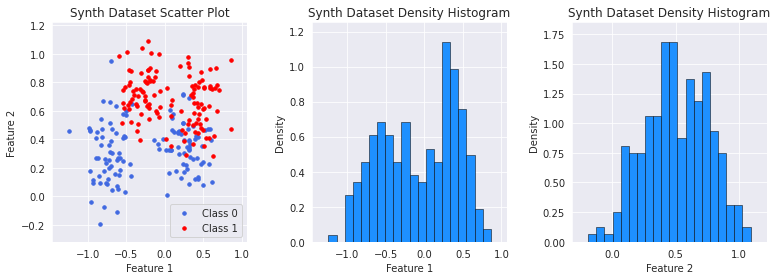

In [12]:
plotter = pl.Plotter(synth_tr, synth_te, pima_tr, pima_te)
plotter.plot_dataset()

## Task 1

### KNN Algorithm

In [13]:
# Located in <project root>/custom_libs/Project2
import custom_libs.Project2.models as models

In [14]:
# kNN for the Synthetic Dataset for k = 2
k = 2
knn_synth = models.KNN(k=k, train=synth_tr)
knn_synth.predict(synth_te)
synth_accuracy, synth_classwise_accuracy, synth_prediction_time = knn_synth.get_statistics()
knn_synth.print_statistics(name='Synthetic')

2021-10-16 19:39:24 Project2 Models INFO     kNN (k=2) for the Synthetic dataset
2021-10-16 19:39:24 Project2 Models INFO     The overall accuracy is: 0.8470
2021-10-16 19:39:24 Project2 Models INFO     The classwise accuracies are: [0.942, 0.752]
2021-10-16 19:39:24 Project2 Models INFO     Total time: 0.0481 sec(s)


In [15]:
# kNN for the Pima Dataset for k = 2
k = 2
knn_pima = models.KNN(k=k, train=pima_tr)
knn_pima.predict(pima_te)
pima_accuracy, pima_classwise_accuracy, pima_prediction_time = knn_pima.get_statistics()
knn_pima.print_statistics(name='Pima')

2021-10-16 19:39:24 Project2 Models INFO     kNN (k=2) for the Pima dataset
2021-10-16 19:39:24 Project2 Models INFO     The overall accuracy is: 0.6898
2021-10-16 19:39:24 Project2 Models INFO     The classwise accuracies are: [0.7522935779816514, 0.6591928251121076]
2021-10-16 19:39:24 Project2 Models INFO     Total time: 0.0125 sec(s)


### 1a - Plot 1x2 figure (overall accuracy vs k) 

In [16]:
def gather_statistics(train: np.ndarray, test: np.ndarray) -> Tuple[List, List, List, List]:
  """ Function that gathers statistics running kNN for input dataset. """

  max_k = int(np.ceil(np.sqrt(train.shape[0]+1)))
  k_range = list(range(1, max_k+1))
  # Run for each k
  accuracies = []
  classwise_accuracies = []
  prediction_times = []
  for k in tqdm(k_range):
    knn_model = models.KNN(k=k, train=train)
    knn_model.predict(test)
    accuracy, classwise_accuracy, prediction_time = knn_model.get_statistics()
    accuracies.append(accuracy)
    classwise_accuracies.append(classwise_accuracy)
    prediction_times.append(prediction_time)

  return k_range, accuracies, classwise_accuracies, prediction_times

In [17]:
# Get statistics for Synthetic Dataset
synth_k_range, synth_accuracies, synth_classwise_accuracies, synth_prediction_times = gather_statistics(synth_tr, synth_te)

  0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
# Get statistics for Pima Dataset
pima_k_range, pima_accuracies, pima_classwise_accuracies, pima_prediction_times = gather_statistics(pima_tr, pima_te)

  0%|          | 0/15 [00:00<?, ?it/s]

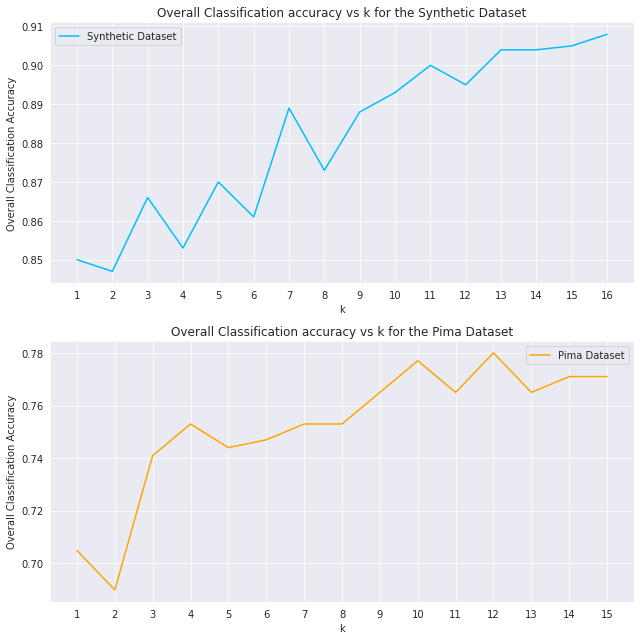

In [19]:
# Plot overall Accuracies
pl.Plotter.plot_knn_overall_accuracies(synth_k_range, synth_accuracies, pima_k_range, pima_accuracies)

### 1b - Generate table similar to project 1 using the optimal parameters for each algorithm

#### Get optimal k for KNN for each dataset

In [20]:
# Get optimal k for each dataset
# Synthetic
synth_k_ind = np.argmax(synth_accuracies)
synth_optimal_k = synth_k_range[synth_k_ind]
# Pima
pima_k_ind = np.argmax(pima_accuracies)
pima_optimal_k = pima_k_range[pima_k_ind]
logger.info(f"Optimal k for the Synthetic Dataset: {synth_optimal_k}", color='yellow')
logger.info(f"Optimal k for the Pima Dataset: {pima_optimal_k}", color='yellow')

2021-10-16 19:39:26 Project2     INFO     Optimal k for the Synthetic Dataset: 16
2021-10-16 19:39:26 Project2     INFO     Optimal k for the Pima Dataset: 12


In [21]:
# Retrieve the statistics
logger.info(f"Pima Dataset Statistics for k={synth_optimal_k}")
logger.info(f"Accuracy: {synth_accuracies[synth_k_ind]}")
logger.info(f"Classwise Accuracy: {synth_classwise_accuracies[synth_k_ind]}")
logger.info(f"Prediction Time: {synth_prediction_times[synth_k_ind]}")
logger.nl()
logger.info(f"Pima Dataset Statistics for k={pima_optimal_k}")
logger.info(f"Accuracy: {pima_accuracies[pima_k_ind]}")
logger.info(f"Classwise Accuracy: {pima_classwise_accuracies[pima_k_ind]}")
logger.info(f"Prediction Time: {pima_prediction_times[pima_k_ind]}")

2021-10-16 19:39:26 Project2     INFO     Pima Dataset Statistics for k=16
2021-10-16 19:39:26 Project2     INFO     Accuracy: 0.908
2021-10-16 19:39:26 Project2     INFO     Classwise Accuracy: [0.928, 0.888]
2021-10-16 19:39:26 Project2     INFO     Prediction Time: 0.03789496421813965

2021-10-16 19:39:26 Project2     INFO     Pima Dataset Statistics for k=12
2021-10-16 19:39:26 Project2     INFO     Accuracy: 0.7801204819277109
2021-10-16 19:39:26 Project2     INFO     Classwise Accuracy: [0.5779816513761468, 0.8789237668161435]
2021-10-16 19:39:26 Project2     INFO     Prediction Time: 0.01230311393737793


#### Get optimal priors and covariance type for the three parametric models for each dataset

In [28]:
# Located in <project root>/custom_libs/Project1
import custom_libs.Project1.parametric_model as pm

In [29]:
# Initialize the parametric classifiers
synth_classifier = pm.ParametricModel(train=synth_tr, test=synth_te)
pima_classifier = pm.ParametricModel(train=pima_tr, test=pima_te)
# Fit the models (retrieve means, stds, covs etc)
synth_classifier.fit()
pima_classifier.fit()

In [30]:
# Setup the different configurations
cases = ("euclidean", "mahalanobis", "quadratic")
priors_c1 = np.linspace(0.01, 1.0, 200, endpoint=False)
first_and_second_case_cov_types = ("avg", "first", "second")

In [31]:
# Calculate statistics for all the cases
statistics = {"synth": {}, "pima": {}}
for case in tqdm(cases, desc='cases'):
    statistics["synth"][case] = {}
    statistics["pima"][case] = {}    
    for cov_type in first_and_second_case_cov_types:
        statistics["synth"][case][cov_type] = {}
        statistics["pima"][case][cov_type] = {}
        for prior_c1 in priors_c1:
            # Synth Dataset
            synth_classifier.predict(mtype=case, priors=[prior_c1, abs(1-prior_c1)], 
                                     first_and_second_case_cov_type=cov_type)
            statistics["synth"][case][cov_type][prior_c1] = synth_classifier.get_statistics(case)
            # Pima Dataset
            pima_classifier.predict(mtype=case, priors=[prior_c1, abs(1-prior_c1)], 
                                     first_and_second_case_cov_type=cov_type)
            statistics["pima"][case][cov_type][prior_c1] = pima_classifier.get_statistics(case)
        if case == "quadratic":
            break

cases:   0%|          | 0/3 [00:00<?, ?it/s]

In [32]:
# Find the best configurations based on overall accuracy
statistics_synth = statistics['synth']
# Get max configuration for synth
synth_max = {}
for case in cases:
    synth_max[case] = {"accuracy": 0.0}
    for cov_type in statistics_synth[case]:
        for prior_c1 in statistics_synth[case][cov_type]:
            curent_statistics = statistics_synth[case][cov_type][prior_c1]
            current_accuracy = curent_statistics[0]
            if current_accuracy > synth_max[case]["accuracy"]:
                synth_max[case]["cov_type"] = cov_type
                synth_max[case]["prior_c1"] = prior_c1
                synth_max[case]["accuracy"] = current_accuracy
                synth_max[case]["classwise_accuracy"] = curent_statistics[1]
                synth_max[case]["prediction_time"] = curent_statistics[2]
# Get max configuration for pima
statistics_pima = statistics['pima']
pima_max = {}
for case in cases:
    pima_max[case] = {"accuracy": 0.0}
    for cov_type in statistics_pima[case]:
        for prior_c1 in statistics_pima[case][cov_type]:
            curent_statistics = statistics_pima[case][cov_type][prior_c1]
            current_accuracy = curent_statistics[0]
            if current_accuracy > pima_max[case]["accuracy"]:
                pima_max[case]["cov_type"] = cov_type
                pima_max[case]["prior_c1"] = prior_c1
                pima_max[case]["accuracy"] = current_accuracy
                pima_max[case]["classwise_accuracy"] = curent_statistics[1]
                pima_max[case]["prediction_time"] = curent_statistics[2]

In [33]:
logger.info('Synthetic and Pima Datasets Best Configurations')
pprint(synth_max)
pprint(pima_max)

2021-10-16 19:43:58 Project2     INFO     Synthetic and Pima Datasets Best Configurations


{'euclidean': {'accuracy': 0.736,
               'classwise_accuracy': [0.536, 0.936],
               'cov_type': 'avg',
               'prediction_time': 0.03800606727600098,
               'prior_c1': 0.34659999999999996},
 'mahalanobis': {'accuracy': 0.898,
                 'classwise_accuracy': [0.894, 0.902],
                 'cov_type': 'avg',
                 'prediction_time': 0.06699466705322266,
                 'prior_c1': 0.4654},
 'quadratic': {'accuracy': 0.901,
               'classwise_accuracy': [0.898, 0.904],
               'cov_type': 'avg',
               'prediction_time': 0.12121129035949707,
               'prior_c1': 0.4654}}
{'euclidean': {'accuracy': 0.786144578313253,
               'classwise_accuracy': [0.5229357798165137, 0.9147982062780269],
               'cov_type': 'avg',
               'prediction_time': 0.007371664047241211,
               'prior_c1': 0.16344999999999998},
 'mahalanobis': {'accuracy': 0.8072289156626506,
                 'classwise_

### 1d - Decision Boundaries

/home/drkostas/GDrive/Projects/UTK/COSC522/custom_libs/Project2/plotter.py:155: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


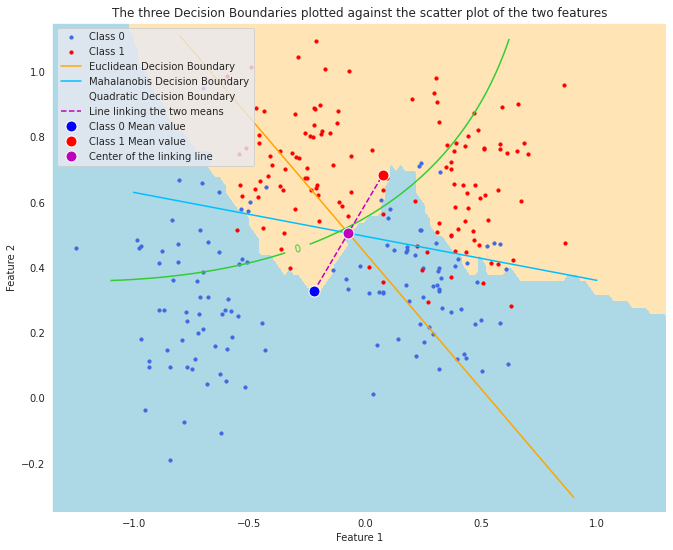

In [ ]:
plot_knn_synth = models.KNN(k=synth_optimal_k, train=synth_tr)
plot_knn_synth.predict(synth_te)
pl.Plotter.plot_decision_boundaries(plot_knn_synth, 0.02)
# pl.Plotter.test(knn=plot_knn_synth, h=0.8)

## Task 2

## Kmeans

In [34]:
# Kmeans for Pima dataset
kmeans_pima = models.Kmeans(train_data=pima_tr, seed=0, k=5)
kmeans_pima.fit()
kmeans_pima.predict(test_data=pima_te, dist='custom')  # custom, cdist, or cdist_sq
# Get statistics and print
kmeans_pima_accuracy, kmeans_pima_classwise_accuracy, \
    kmeans_pima_prediction_time, kmeans_pima_iterations, kmeans_pima_membership_changes \
    = kmeans_pima.get_statistics()
kmeans_pima.print_statistics(name='Pima')

2021-10-16 20:10:51 Project2 Models INFO     Kmeans for the Pima dataset
2021-10-16 20:10:51 Project2 Models INFO     The overall accuracy is: 0.2560
2021-10-16 20:10:51 Project2 Models INFO     The classwise accuracies are: [0.29357798165137616, 0.23766816143497757]
2021-10-16 20:10:51 Project2 Models INFO     Total Iterations: 12
2021-10-16 20:10:51 Project2 Models INFO     Total time: 0.0026 sec(s)


## WTA

In [35]:
# WTA for Pima dataset
epsilon = 0.1
wta_pima = models.WTA(train_data=pima_tr, seed=1)
wta_pima.fit()
wta_pima.predict(test_data=pima_te, epsilon=epsilon)
# Get statistics and print
wta_pima_accuracy, wta_pima_classwise_accuracy, \
    wta_pima_prediction_time, wta_pima_iterations, wta_pima_membership_changes \
    = wta_pima.get_statistics()
wta_pima.print_statistics(name='Pima')

2021-10-16 20:10:52 Project2 Models INFO     WTA for the Pima dataset
2021-10-16 20:10:52 Project2 Models INFO     The overall accuracy is: 0.7108
2021-10-16 20:10:52 Project2 Models INFO     The classwise accuracies are: [0.44954128440366975, 0.8385650224215246]
2021-10-16 20:10:52 Project2 Models INFO     Total Iterations: 6
2021-10-16 20:10:52 Project2 Models INFO     Total time: 0.0286 sec(s)


### 2a - Plot "percentage of samples changing membership" vs. "epoch"

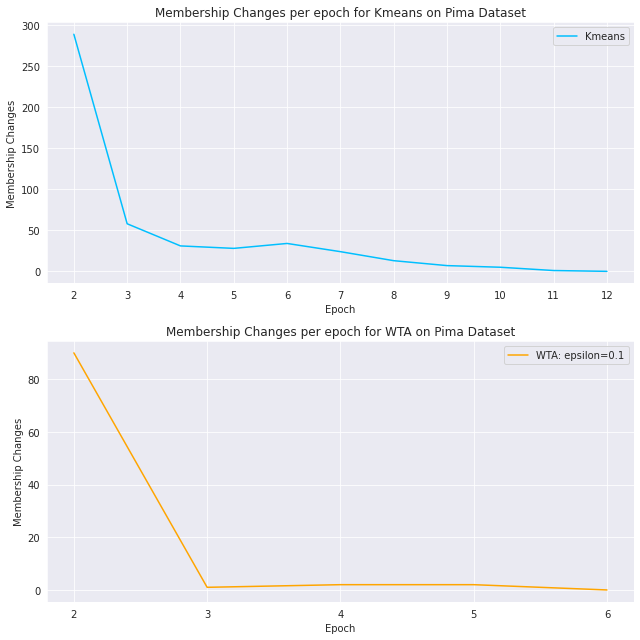

In [36]:
pl.Plotter.plot_membership_changes(kmeans_pima_membership_changes, wta_pima_membership_changes, epsilon)